<a href="https://colab.research.google.com/github/ihasdapie/Colab-Notebooks/blob/master/Siamese_Signature_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Signature Verification Siamese Neural Network**

Brian Chen | 2019

In [0]:
#get data
pip install gdown

In [0]:
!gdown --id 1v5eGVp6aaSIsozIgmB1oOQjQU-l0AH90 --output /content/data.zip

Downloading...
From: https://drive.google.com/uc?id=1v5eGVp6aaSIsozIgmB1oOQjQU-l0AH90
To: /content/data.zip
3.99MB [00:00, 125MB/s]


In [0]:
#@title imports
import zipfile
import os
import keras
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time
import tensorflow as tf

from keras.preprocessing.image import img_to_array, load_img
from keras.layers import BatchNormalization, Dense, Dropout, Input, Lambda, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import Sequential
from keras import backend
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import sigmoid
from keras.regularizers import l2
from keras.layers import Layer #or do i have to use the keras.engine.topolgy? will see.
from keras.utils import to_categorical, plot_model, Sequence
from keras.models import Model
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split

# plt.xkcd()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

Using TensorFlow backend.


In [0]:
#extract data
z = zipfile.ZipFile('/content/data.zip', 'r')
z.extractall('/content/dataset')
z.close()

In [0]:
#@title Parameters

num_batch = 16 #@param {type: "integer"}
num_epochs = 128 #@param {type: "integer"}
validate_every = 250 #@param {type: "integer"}
num_pairs = 1722 #@param {type: "integer"}
learning_rate = 0.0001 #@param {type: "number"}
h = 100 #@param {type: "integer"}
w = 80 #@param {type: "integer"}
shape = (h, w, 1)

real_dir = "/content/dataset/ProcessedGenuine"
fake_dir = "/content/dataset/ProcessedForgeries"

In [0]:
#@title load_data(dir, shape, label):
def load_data(dir, shape, label = "nolabel" ):
  #returns image array of shape (size, h, w, 1) given directory

  img_array = [cv2.convertScaleAbs(img_to_array(load_img(dir+"/"+x, color_mode = "grayscale", target_size=(shape[0:2])))) for x in os.listdir(dir)]
  img_array = [img.reshape(shape) for img in img_array]
  img_array = np.asarray(img_array)
  if label == "nolabel":
    return img_array
  else:
    label_array = [label for x in range(len(img_array))]



    #use numpy arrays instead.

    # n_img = len(os.listdir(dir))

    # img_array = np.zeros((n_img, 1))

    # for x in os.listdir(dir):
    #   np.append(img_array, cv2.convertScaleAbs(img_to_array(load_img(dir+"/"+x, color_mode = "grayscale" ))))
    
    # label_array = np.zeros((n_img, 1))

    # for x in range(n_img):
    #   np.append(label_array, label)

    return img_array, label_array

In [0]:
#@title make_training_set(real_dir ,fake_dir, shape, size)
def make_training_set(real_dir, fake_dir, shape, size):
# return pairs & true/false labels

  X_real = load_data(real_dir, shape)/255
  X_fake = load_data(fake_dir, shape)/255
# 1 = genuine pair
# 0 = false pair

# list of size size of 0,1 for genuine/fake pairs
# 0 = real,real -> Y = 1 (true match)
# 1 = real,fake -> Y = 0 (no match)

#return_shape = (n_pairs, pairsize (2), h, w, 1)

  X_train = np.zeros(shape = (size, 2, shape[0], shape[1], 1))
  Y_train = np.zeros(shape = (size, 1))
  seed = np.random.randint(0, 2, size = size)
  for x in range(seed.shape[0]):
    if seed[x] == 0:
      img_1 = X_real[np.random.randint(0,X_real.shape[0])]
      img_2 = X_real[np.random.randint(0,X_real.shape[0])]
      X_train[x, 0, :, :, 0] = img_1.reshape(shape[0], shape[1])
      X_train[x, 1, :, :, 0] = img_2.reshape(shape[0], shape[1])
      Y_train[x] = 1

    if seed[x] == 1:
      img_1 = X_real[np.random.randint(0,X_real.shape[0])]
      img_2 = X_fake[np.random.randint(0,X_fake.shape[0])]
      X_train[x, 0, :, :, 0] = img_1.reshape(shape[0], shape[1])
      X_train[x, 1, :, :, 0] = img_2.reshape(shape[0], shape[1])
      Y_train[x] = 0

  # Y_train = to_categorical(Y_train) #techically not necessary because everything is 0/1 already, but I wanted to do it.

  return X_train, Y_train

In [0]:
def bias_initializer(shape, dtype = None):
  #intial random normal distrubution bias for dense layers
  return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [0]:
#@title create_network(shape):

def create_network(shape):
  net = Sequential()
  #conv/fc layer -> batchnorm -> activation -> dropout
  #using tensorflow backend, so dataformat = 'channels_last'
  
  net.add(Convolution2D(32,  kernel_size=(4,4), padding = 'valid', data_format = "channels_last", bias_initializer= bias_initializer,
                        input_shape = shape, kernel_initializer= "glorot_normal", kernel_regularizer = l2(2e-4)))
  net.add(BatchNormalization())
  net.add(LeakyReLU(alpha = (0.3)))
  net.add(MaxPooling2D(pool_size=(2,2)))
  net.add(Dropout(0.3))
  
  net.add(Convolution2D(64,  kernel_size=(2,2), padding = 'valid', data_format = "channels_last", bias_initializer= bias_initializer,
                        kernel_initializer= "glorot_normal", kernel_regularizer=l2(2e-4)))
  net.add(BatchNormalization())
  net.add(LeakyReLU(alpha = (0.3)))
  net.add(MaxPooling2D(pool_size = (2,2)))
  net.add(Dropout(0.3))
  
  
  net.add(Flatten())

  net.add(Dense(64, kernel_initializer= "glorot_normal", kernel_regularizer= l2(2e-4),
                bias_initializer= bias_initializer))
  net.add(LeakyReLU(alpha = (0.3)))
  net.add(Dropout(0.3))
  
  net.add(Dense(64, activation = 'sigmoid', bias_initializer= bias_initializer, kernel_regularizer= l2(2e-4)))
  
  return net

In [0]:
#@title show_img
def show_img(img, title= ""):
  #displays image
  plt.imshow(img, cmap = 'gray')
  plt.title(title)

In [0]:
#@title make training arrays
X_train, Y_train = make_training_set(real_dir, fake_dir, shape, num_pairs)

In [0]:
#train model on a part of the training set, verify accuracy on untouched set
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=.25)
img_1_array = x_train[:,0]
img_2_array = x_train[:,1]

In [0]:
#create & compile siamese model
steven = create_network(shape)
steven.summary()

input_1 = Input(shape=shape)
input_2 = Input(shape=shape)

network_1 = steven(input_1)
network_2 = steven(input_2)

dist_layer = Lambda(lambda tensors:backend.abs(tensors[0]-tensors[1]))
distance = dist_layer([network_1, network_2])

output = Dense(1, activation= "sigmoid", bias_initializer= bias_initializer)(distance)

adam = keras.optimizers.adam(lr = learning_rate)

steven_model = Model(input=[input_1, input_2], output = output)

steven_model.compile(loss = keras.losses.binary_crossentropy , optimizer = adam, metrics = ["accuracy"])
plot_model(steven_model, show_shapes=True, expand_nested=True,  show_layer_names=True, to_file='model.png')
steven_model.summary()












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 97, 77, 32)        544       
_________________________________________________________________
batch_normalization_1 (Batch (None, 97, 77, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 97, 77, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 38, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 38, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 37, 64)        8256 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 80, 1)   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100, 80, 1)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64)           1709152     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 64)           0           sequential_1[1][0]         

In [0]:
#to use pre-trained model weights... 
!gdown --id 1hlSa5iEBRDm0cOmarDwpsYQQ52-CY9V6 --output /content/steven.h5
steven_model.load_weights('/content/steven.h5')

Downloading...
From: https://drive.google.com/uc?id=1hlSa5iEBRDm0cOmarDwpsYQQ52-CY9V6
To: /content/steven.h5
6.86MB [00:00, 109MB/s]


## **model diagram**

![model diagram](https://drive.google.com/uc?id=1ipmJ4-gq4L58tY0aZnjehFht2Lw-y90N)

In [0]:
#train model
#this takes about 8-10 minutes
#to train a model from scractch, ensure all the data is loaded, and run "create model" without loading the previous model
# ^^make sure you have connected to a server with the connect button in the top right corner!

history = steven_model.fit(x=[img_1_array, img_2_array], y = y_train, validation_split = 0.25, validation_steps = int(np.abs(np.ceil(num_epochs/num_batch))),
                 epochs = num_epochs, verbose = 1, steps_per_epoch= int(np.abs(np.ceil(num_epochs/num_batch))))



Train on 968 samples, validate on 323 samples
Epoch 1/128
8/8 [==============================] - 5s 650ms/step - loss: 0.7043 - acc: 0.6180 - val_loss: 0.6079 - val_acc: 0.7678
Epoch 2/128
8/8 [==============================] - 3s 416ms/step - loss: 0.5651 - acc: 0.7974 - val_loss: 0.4780 - val_acc: 0.8824
Epoch 3/128
8/8 [==============================] - 3s 416ms/step - loss: 0.4430 - acc: 0.8905 - val_loss: 0.3735 - val_acc: 0.9536
Epoch 4/128
8/8 [==============================] - 3s 415ms/step - loss: 0.3485 - acc: 0.9522 - val_loss: 0.3074 - val_acc: 0.9845
Epoch 5/128
8/8 [==============================] - 3s 415ms/step - loss: 0.2855 - acc: 0.9850 - val_loss: 0.2653 - val_acc: 0.9876
Epoch 6/128
8/8 [==============================] - 3s 415ms/step - loss: 0.2417 - acc: 0.9913 - val_loss: 0.2723 - val_acc: 0.9814
Epoch 7/128
8/8 [==============================] - 3s 416ms/step - loss: 0.2158 - acc: 0.9942 - val_loss: 0.2775 - val_acc: 0.9752
Epoch 8/128
8/8 [==================

In [0]:
#save weights (no need to run )
steven_model.save_weights('/content/drive/My Drive/Brians_Signature_Verification_Project/steven.h5')

In [0]:
#create predictions: 0 for fake, 1 for real
#pred is a list of probabilities from 0 to 1. This can be seperated into true/false with a simple "<0.5"
pred = steven_model.predict([x_test[:,0], x_test[:,1]])

In [0]:
labels = {0:"Fake", 1:"Real"}

In [0]:
#display accuracy
# 0 = fake, 1 = real

print("accuracy: ",(1-y_test[pred.ravel()<0.5].mean())*100, "%")

# count = 0
# for x in range(len(b)):
#   if b[x] == np.round(a[x],0):
#     count = count + 1
# print("accuarcy: ", count/len(b)*100, "%")

num_display = 10 #@param {type: "integer"}
for x in range(num_display):
  print("Prediction: ", labels[int(np.round(pred[x], 0))], " Reference: ", labels[int(y_test[x])])

accuracy:  100.0 %
Prediction:  Fake  Reference:  Fake
Prediction:  Real  Reference:  Real
Prediction:  Real  Reference:  Real
Prediction:  Real  Reference:  Real
Prediction:  Fake  Reference:  Fake
Prediction:  Fake  Reference:  Fake
Prediction:  Real  Reference:  Real
Prediction:  Real  Reference:  Real
Prediction:  Real  Reference:  Real
Prediction:  Fake  Reference:  Fake


In [0]:
def show_prediction(x_test, y_test, pred, ind = None):
  #displays an image pair and predicted/reference value given index (random if none provided)
  #I couldn't figure out subplots to display them side by side so they go up-down and only one at a time
  if ind == None:
    ind = np.random.randint(0, len(pred))

  ref_img = plt.plot()
  plt.axis('off')
  plt.imshow(x_test[ind,0,:,:,0], cmap = "gray")
  #note that the first one of every pair is always real - that is what the second image is being compared against
  title = "Reference #" + str(ind) +  " " + "(Real)"
  plt.title(title)
  plt.show()

  questioned_img = plt.plot()
  plt.axis('off')
  plt.imshow(x_test[ind,1,:,:,0], cmap = "gray")
  #the second image is questioned: "unknown". 
  title = "Questioned  #" + str(ind) +  "\n\n " + "  Predicted Value: " + labels[int(np.round(pred[ind], 0))] + "  Actual: "+ labels[int(y_test[ind])] 
  plt.title(title)
  plt.show()
  certainty = np.abs(pred[ind]-0.5)/0.50
  print("Certainty: ", certainty*100, "%")

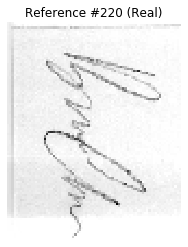

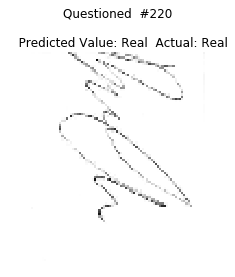

Certainty:  [88.857796] %


In [0]:
show_prediction(x_test, y_test, pred)

the first image is always real: it is the reference against which the questioned image is compared against. The predicted value is the real/fake predicted by the network, while the actual value is the known value.

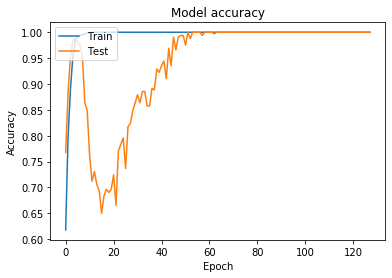

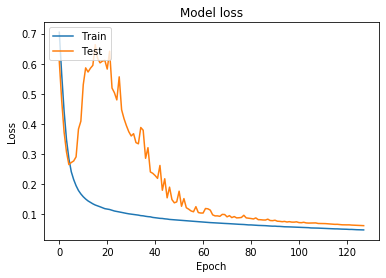

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

the test accuracy trends can be explained by the model initially overfitting to training data

Verifying Mr. Ark's forgery


In [0]:
forgeries = load_data("/content/dataset/ProcessedForgeries", shape = shape)/255
genuine = load_data("/content/dataset/ProcessedGenuine", shape = shape)/255

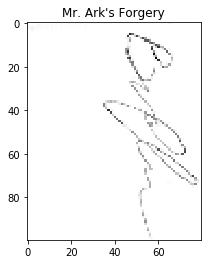

In [0]:
#this is mr.ark's forgery
#make ark pairs
#ark = #21
arkfake = forgeries[21]
show_img(arkfake.reshape(shape[0], shape[1]), title = "Mr. Ark's Forgery")

num_ark = 12 #@param {type: "integer"}

arkpair = np.zeros(shape = (num_ark, 2, shape[0], shape[1], 1))
arky = np.zeros(shape = (num_ark, 1))

for x in range(num_ark):
      img_1 = genuine[np.random.randint(0,genuine.shape[0])]
      arkpair[x, 0, :, :, 0] = img_1.reshape(shape[0], shape[1])
      arkpair[x, 1, :, :, 0] = arkfake.reshape((shape[0], shape[1]))
      arky[x] = 0


In [0]:
arkpred = steven_model.predict(x = [arkpair[:,0], arkpair[:,1]])

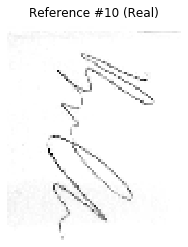

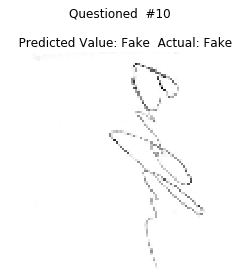

Certainty:  [97.46026] %


In [0]:
show_prediction(arkpair, arky, arkpred)